# ⭐**Conditional Workflow**

### 🧱 **Evolution of Workflows in LangGraph**

1. **Sequential Workflows**:

   * Tasks run one after another in a fixed order.
   * Example: `Task A` → `Task B` → `Task C`.

2. **Parallel Workflows**:

   * Tasks split and run *simultaneously* from a single point.
   * Example: After `Task 1`, both `Task 2` and `Task 3` run in parallel → their outputs feed into `Task 4`.

---

### 🔀 **Introduction to Conditional Workflows**

3. **Core Concept**:

   * Like parallel workflows in structure but with a key difference: **only one branch is executed**, based on a **condition**.
   * Works similar to **if-else logic** in programming.

4. **Programming Analogy**:

   * Comparable to `if-elif-else` statements.
   * Only the branch matching the condition is followed; others are skipped.

5. **Significance**:

   * Essential for **complex, decision-based** workflows.
   * Expected to be used **frequently** in advanced LangGraph applications—just like `if-else` is in regular coding.

## ⭕ **Quadratic Equation Workflow**

## Quadratic Equation Solver: Mathematical Formulas

The code implements a solver for the standard quadratic equation:

$ax^2 + bx + c = 0$

---

### 1. Show the Equation

Displays the equation in standard form:

$ax^2 + bx + c = 0$



---

### 2. Calculate the Discriminant

Computes the discriminant $D$:


$D = b^2 \;-\; 4ac$



---

### 3. Solve Based on Discriminant

**Branching logic** (in `check_condition`):

- If $D > 0$, there are two distinct real roots.  
- If $D = 0$, there is exactly one (repeated) real root.  
- If $D < 0$, there are no real roots.

---

#### Case A: Two Real Roots \((D > 0)\)


$x = \frac{-b \pm \sqrt{D}}{2a}$



Which expands to  

$x_1 = \frac{-b + \sqrt{b^2 - 4ac}}{2a}$

$x_2 = \frac{-b - \sqrt{b^2 - 4ac}}{2a}$



---

#### Case B: One Repeated Root \((D = 0)\)

$x = \frac{-b}{2a}$ 


---

#### Case C: No Real Roots \((D < 0)\)

No solutions in the set of real numbers.



## ⭕ **Loan Approval System**

**We'll build a LangGraph workflow that:**

- Gathers applicant data
- Calculates a credit score
- Decides based on multiple thresholds:
  - 🟢 Approve loan
  - 🟡 Refer to manual review
  - 🔴 Reject loan
- Each condition leads to a different downstream path with more logic.

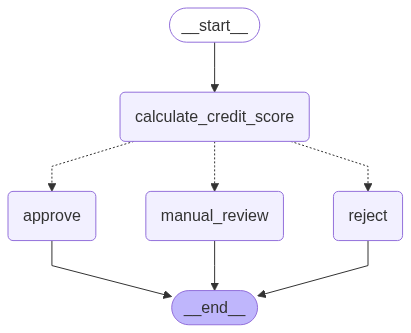

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

class LoanState(TypedDict):
    name: str
    age: int
    income: float
    loan_amount: float
    credit_score: float
    decision: str
    remarks: str

# Step 1: Calculate Credit Score
def calculate_credit_score(state: LoanState):
    score = (state["income"] / state["loan_amount"]) * 100
    return {"credit_score": score}

# Step 2: Evaluate Credit Score
def evaluate_credit_score(state: LoanState) -> Literal["approve", "manual_review", "reject"]:
    score = state["credit_score"]
    if score >= 250:
        return "approve"
    elif 150 <= score < 250:
        return "manual_review"
    else:
        return "reject"

# Step 3a: Auto-Approval Logic
def approve_loan(state: LoanState):
    return {
        "decision": "Approved ✅",
        "remarks": f"Loan approved for {state['name']} with credit score {state['credit_score']:.2f}"
    }

# Step 3b: Manual Review Path
def manual_review(state: LoanState):
    remarks = f"Loan referred for manual review for {state['name']}."
    return {"decision": "Pending Manual Review 🕵️‍♂️", "remarks": remarks}

# Step 3c: Auto-Rejection Logic
def reject_loan(state: LoanState):
    return {
        "decision": "Rejected ❌",
        "remarks": f"Loan rejected for {state['name']} due to low credit score ({state['credit_score']:.2f})"
    }

# Create graph
graph = StateGraph(LoanState)

graph.add_node("calculate_credit_score", calculate_credit_score)
graph.add_node("approve", approve_loan)
graph.add_node("manual_review", manual_review)
graph.add_node("reject", reject_loan)

# Connect nodes
graph.add_edge(START, "calculate_credit_score")
graph.add_conditional_edges("calculate_credit_score", evaluate_credit_score)
graph.add_edge("approve", END)
graph.add_edge("manual_review", END)
graph.add_edge("reject", END)

# Compile the workflow
workflow = graph.compile()

workflow

In [7]:
initial_state = {
    "name": "Alice",
    "age": 30,
    "income": 6000,
    "loan_amount": 200,
}

result = workflow.invoke(initial_state)
print(result)

{'name': 'Alice', 'age': 30, 'income': 6000, 'loan_amount': 200, 'credit_score': 3000.0, 'decision': 'Approved ✅', 'remarks': 'Loan approved for Alice with credit score 3000.00'}


## ⭕ **Smart Customer Support Bot with Escalation Path**

**🔍 Goal:**
***Create a multi-path workflow that:***
- Handles customer complaints
- Uses basic NLP logic to route tickets
- Escalates to a human agent if:
  - *User is angry (based on sentiment)*
  - *Or it's a high-priority issue*
  - *Or the bot failed to resolve the issue*
- Resolves simple issues automatically

---

**💡 Core Concepts Used:**
- Conditional branching based on sentiment + issue category
- Auto-resolution vs escalation
- NLP-like keyword-based routing

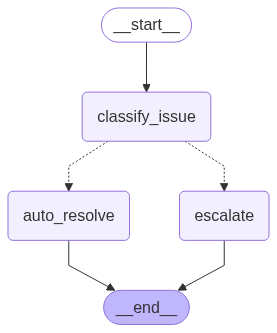

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

class SupportState(TypedDict):
    user_name: str
    issue: str
    sentiment: str
    category: str
    decision: str
    resolution: str

# Step 1: Simple Sentiment + Category Classification (mocked)
def classify_issue(state: SupportState):
    issue = state["issue"].lower()
    sentiment = "angry" if "refund" in issue or "worst" in issue else "neutral"
    
    if "payment" in issue or "refund" in issue:
        category = "billing"
    elif "login" in issue:
        category = "authentication"
    elif "feature" in issue:
        category = "product"
    else:
        category = "general"
    
    return {"sentiment": sentiment, "category": category}

# Step 2: Condition-Based Decision Path
def route_ticket(state: SupportState) -> Literal["auto_resolve", "escalate"]:
    # Escalate if angry or critical category
    if state["sentiment"] == "angry" or state["category"] in ["billing", "authentication"]:
        return "escalate"
    return "auto_resolve"

# Step 3a: Auto-Resolution
def auto_resolve(state: SupportState):
    msg = f"Hi {state['user_name']}, we’ve resolved your issue regarding {state['category']} ✅"
    return {"decision": "Resolved Automatically", "resolution": msg}

# Step 3b: Escalate to Human
def escalate(state: SupportState):
    msg = f"Hi {state['user_name']}, your {state['category']} issue has been escalated to a human agent 🚨"
    return {"decision": "Escalated to Human", "resolution": msg}

# Build the graph
graph = StateGraph(SupportState)

graph.add_node("classify_issue", classify_issue)
graph.add_node("auto_resolve", auto_resolve)
graph.add_node("escalate", escalate)

graph.add_edge(START, "classify_issue")
graph.add_conditional_edges("classify_issue", route_ticket)
graph.add_edge("auto_resolve", END)
graph.add_edge("escalate", END)

workflow = graph.compile()
workflow

In [9]:
workflow.invoke({
    "user_name": "Rohit",
    "issue": "I want a refund! Worst service ever.",
})

{'user_name': 'Rohit',
 'issue': 'I want a refund! Worst service ever.',
 'sentiment': 'angry',
 'category': 'billing',
 'decision': 'Escalated to Human',
 'resolution': 'Hi Rohit, your billing issue has been escalated to a human agent 🚨'}